In [1]:
import ast
import pandas as pd 
import glob
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from sklearn.metrics import silhouette_score
from dotenv import load_dotenv
import seaborn as sns
from usflc_xai import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc
load_dotenv()

CROP_IMAGE_DIR = os.getenv('CROP_IMAGE_DIR_PATH')
test_data_id = '09'
metadata_name = 'meta_data/TWB_ABD_expand_modified_gasex_21072022.csv'
test_data_list_name = 'fattyliver_2_class_certained_0_123_4_20_40_dataset_lists/dataset'+str(test_data_id)+'/test_dataset'+str(test_data_id)+'.csv'
test_data_list = pd.read_csv(test_data_list_name)
meta_data = pd.read_csv(metadata_name, sep=",")

image_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_name = 'model_tl_twbabd'+str(test_data_id)+'/best_results.ckpt'
image_encoder_id = 'densenet121'
graph_encoder_id = 'SETNET_GAT'
num_classes = 2
input_dim = 1024
num_layers = 1
transform = transforms.Compose([
transforms.Grayscale(num_output_channels=3),
transforms.Resize([224, 224]),
transforms.ToTensor(),
transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

## Call pretrained image encoder ###
_, pretrained_image_encoder = models.image_encoder_model(name=image_encoder_id, 
                                        pretrained=True, 
                                        num_classes=num_classes, 
                                        device=device)
pretrained_image_encoder = pretrained_image_encoder.eval() 


## Subject id in the test data ##
mi_id = test_data_list['MI_ID'][0]
mi_id = "P0012750"
## Obtain image ids and label y for each subject. ###
img_id_list = ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])
print(mi_id, len(img_id_list), img_id_list)
y = 1

P0012750 25 ['IMG0001', 'IMG0002', 'IMG0003', 'IMG0004', 'IMG0005', 'IMG0006', 'IMG0007', 'IMG0008', 'IMG0009', 'IMG0010', 'IMG0011', 'IMG0013', 'IMG0014', 'IMG0016', 'IMG0018', 'IMG0021', 'IMG0022', 'IMG0023', 'IMG0024', 'IMG0025', 'IMG0026', 'IMG0027', 'IMG0029', 'IMG0030', 'IMG0032']


In [2]:
ground_truth_pos_mi_ids = [mi_id
         for mi_id in test_data_list['MI_ID'] 
         if meta_data[meta_data['MI_ID']==mi_id]['liver_fatty'].to_list()[0]  > 0 ]
selected_mi_ids = [mi_id for mi_id in ground_truth_pos_mi_ids
                   if len(ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])) >= 20
                   ]
selected_mi_ids = list(set(selected_mi_ids))
print(len(ground_truth_pos_mi_ids), len(selected_mi_ids))

445 135


In [3]:
img_id_list = ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])
img_abs_filepaths = [CROP_IMAGE_DIR + str(mi_id) +'_'+str(i)+'.jpg' for i in img_id_list]
assert(len(img_abs_filepaths) == len(img_id_list))
assert(all(os.path.exists(i) for i in img_abs_filepaths))

In [4]:
import numpy as np
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
from dataclasses import dataclass, field
from typing import Callable, Union
from classifiers import RidgeClassifierWithStats

In [5]:
def select_unique_columns(df):
    # Transpose the dataframe to compare columns
    df_t = df.T

    # Drop duplicate rows (which were originally columns)
    df_unique = df_t.drop_duplicates()
    
    # Transpose back to original orientation
    return df_unique.T

df = pd.read_csv("/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/07-12-2024-03-57-58/P0012750/pred_results.csv")
df = df.drop_duplicates()
X_df = df.drop(['yhat', 'y'], axis=1).copy()
print(X_df.shape)
# X_df = select_unique_columns(X_df)
print(X_df.shape)
y_df = df[['yhat']].copy()
y_ = y_df.to_numpy().ravel()
# X_df = StandardScaler().fit_transform(X_df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.10, random_state=42)
y_train, y_test = y_train.to_numpy().ravel(), y_test.to_numpy().ravel()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
df

(804, 25)
(804, 25)
(723, 25) (723,) (81, 25) (81,)


,IMG0001,IMG0002,IMG0003,IMG0004,IMG0005,IMG0006,IMG0007,IMG0008,IMG0009,IMG0010,...,IMG0023,IMG0024,IMG0025,IMG0026,IMG0027,IMG0029,IMG0030,IMG0032,yhat,y
0,1,0,1,0,1,0,0,1,0,1,...,1,0,0,0,0,0,0,0,1,1
1,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,0,1,1,0,1,1
2,0,1,1,0,1,0,0,1,1,0,...,1,0,1,0,1,0,1,1,1,1
3,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,0,1,1,1,...,1,1,0,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0,1,1,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
990,0,1,1,1,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
994,0,1,1,1,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,1
996,0,1,1,1,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


Best ROC-AUC: 0.9685744588744589 for best alpha: 0.29285714285714287
Mean accuracy on training data:  0.8930348258706468
Intercept value:  0.34292291091338006


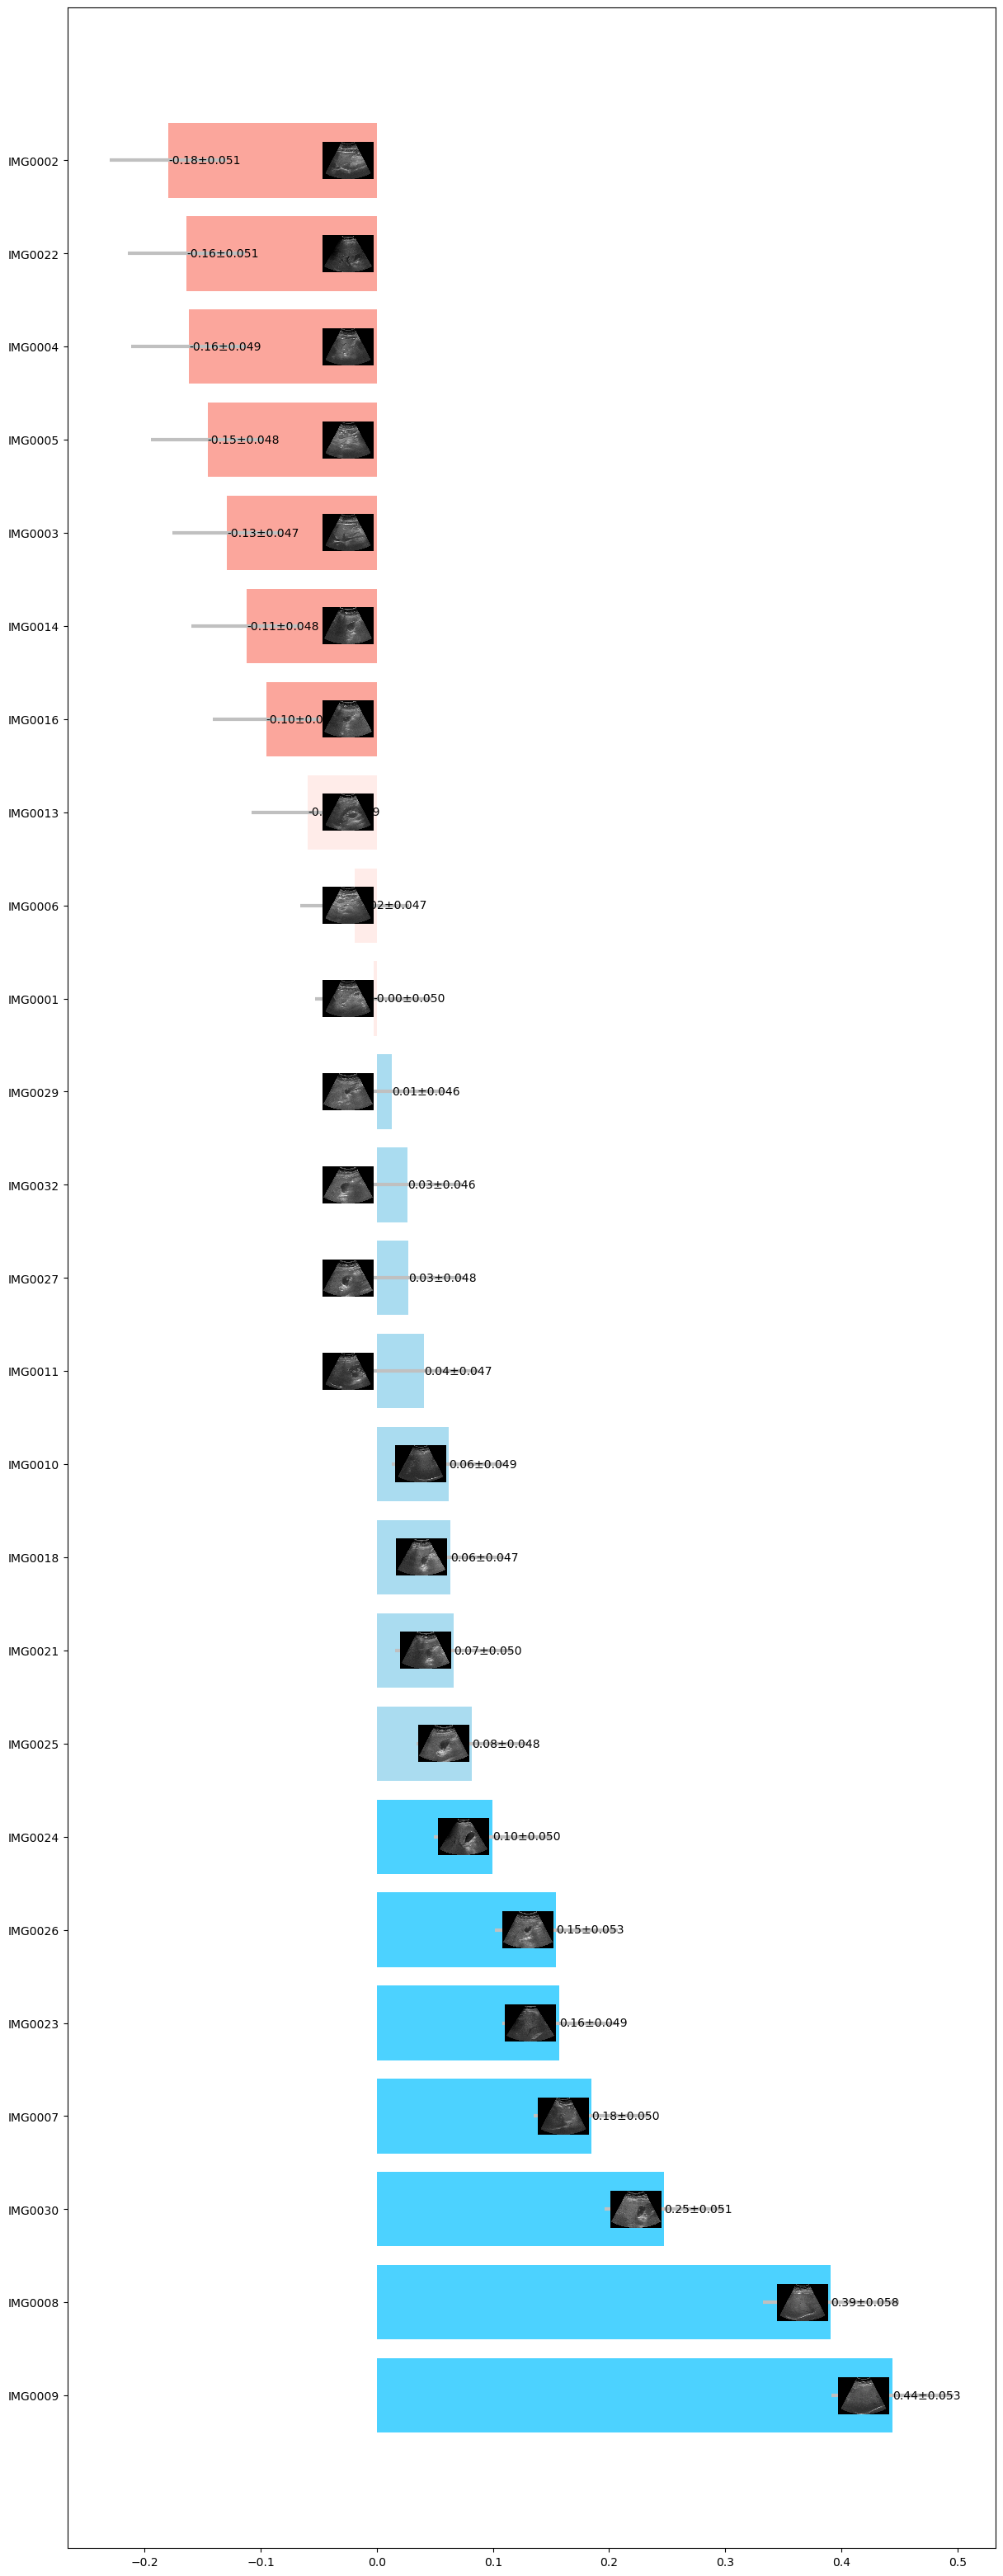

<Figure size 640x480 with 0 Axes>

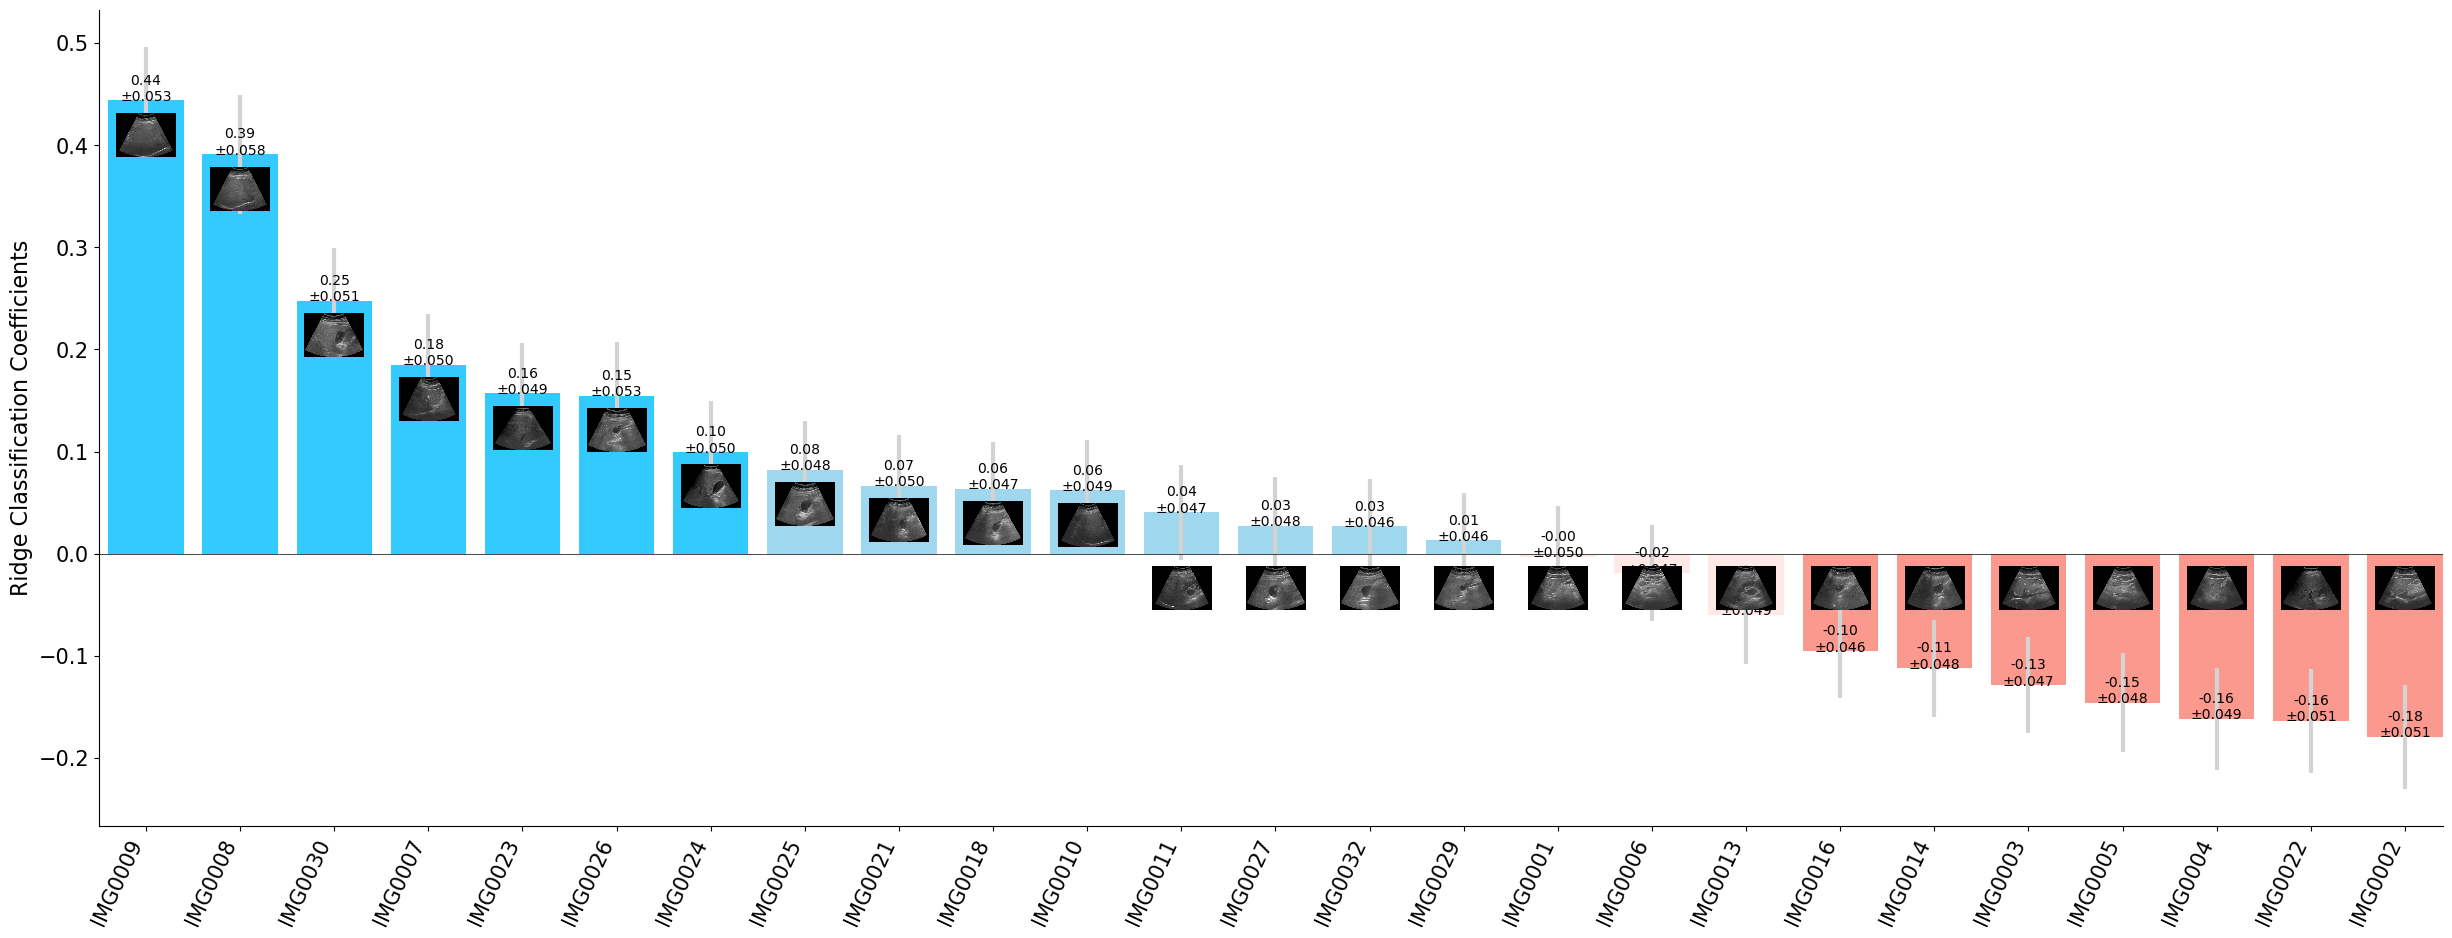

,Estimate,SE,BoostrapLowerCI,BoostrapUpperCI,SELowerCI,SEUpperCI,BootstrapSignificance,SESignificance
IMG0001,-0.003057,0.049775,-0.103901,0.091213,-0.100616,0.094501,INSIGNIFICANT,INSIGNIFICANT
IMG0002,-0.179382,0.050558,-0.277304,-0.079441,-0.278476,-0.080288,SIGNIFICANT,SIGNIFICANT
IMG0003,-0.128848,0.047057,-0.221128,-0.036647,-0.221080,-0.036616,SIGNIFICANT,SIGNIFICANT
IMG0004,-0.161816,0.049471,-0.259358,-0.066019,-0.258779,-0.064853,SIGNIFICANT,SIGNIFICANT
IMG0005,-0.145792,0.048391,-0.240308,-0.052793,-0.240640,-0.050945,SIGNIFICANT,SIGNIFICANT
IMG0006,-0.019180,0.047020,-0.110581,0.073701,-0.111340,0.072980,INSIGNIFICANT,INSIGNIFICANT
IMG0007,0.184888,0.050107,0.086557,0.281145,0.086679,0.283097,SIGNIFICANT,SIGNIFICANT
IMG0008,0.391030,0.058327,0.279728,0.509965,0.276708,0.505352,SIGNIFICANT,SIGNIFICANT
IMG0009,0.443773,0.052616,0.346487,0.553325,0.340645,0.546900,SIGNIFICANT,SIGNIFICANT
IMG0010,0.062021,0.049138,-0.035421,0.159167,-0.034290,0.158331,INSIGNIFICANT,INSIGNIFICANT


<Figure size 640x480 with 0 Axes>

In [6]:
mi_id = "P0012750"
save_dir = "/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/P0012750-RIDGE-RESULTS/"
img_id_list = ast.literal_eval(meta_data[meta_data['MI_ID']==mi_id]['IMG_ID_LIST'].to_list()[0])
img_abs_filepaths = [CROP_IMAGE_DIR + str(mi_id) +'_'+str(i)+'.jpg' for i in img_id_list]
model = RidgeClassifierWithStats(n_alphas=50, n_bootstrap=10000)
model.custom_fit(X_df, y_)

# Print summary
summary_df = model.summary()
model.plot_results(img_filepaths = img_abs_filepaths,
                   summary_df = summary_df,
                   save_dir = save_dir)

summary_df.to_csv(os.path.join(save_dir, "ridge_coefficients.csv"), index=None)
summary_df

In [9]:
labels = list(summary_df.index)
values = [summary_df["Estimate"][i] 
                    for i in range(len(labels))
                    ]
ses = [summary_df["SE"][i] 
                    for i in range(len(labels))
                    ]
bar_labels = [f"{values[indx]:.2f}±{se:.3f}" for indx, se in enumerate(ses)]
bar_labels

['0.00±0.000',
 '-0.00±0.000',
 '-0.00±0.000',
 '-0.00±0.000',
 '-0.00±0.000',
 '-0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '-0.00±0.000',
 '-0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '-0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000',
 '0.00±0.000']

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:10<00:00,  3.10s/it]


Best ROC-AUC: 0.9995794785534062
Accuracy from best alpha: 0.9834254143646409
Refitting model with best alpha 0.41000000000000003
Best alpha value:  0.41000000000000003
Best lambda value:  0.00015402708180471393
Intercept value:  -0.35494831845003283
Boostrapping...


100%|██████████| 100/100 [00:00<00:00, 334207.49it/s]


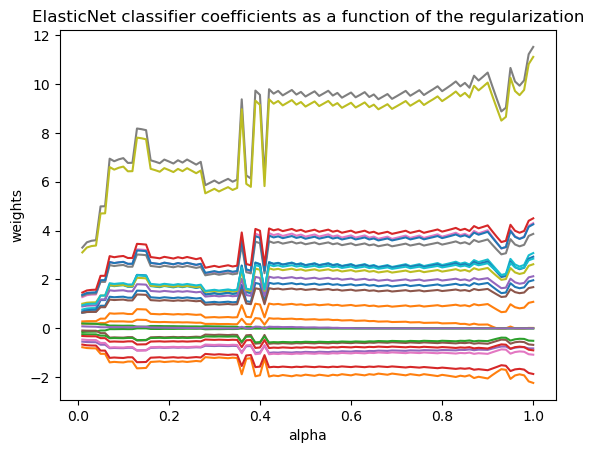

AUC on holdout test set 1.0


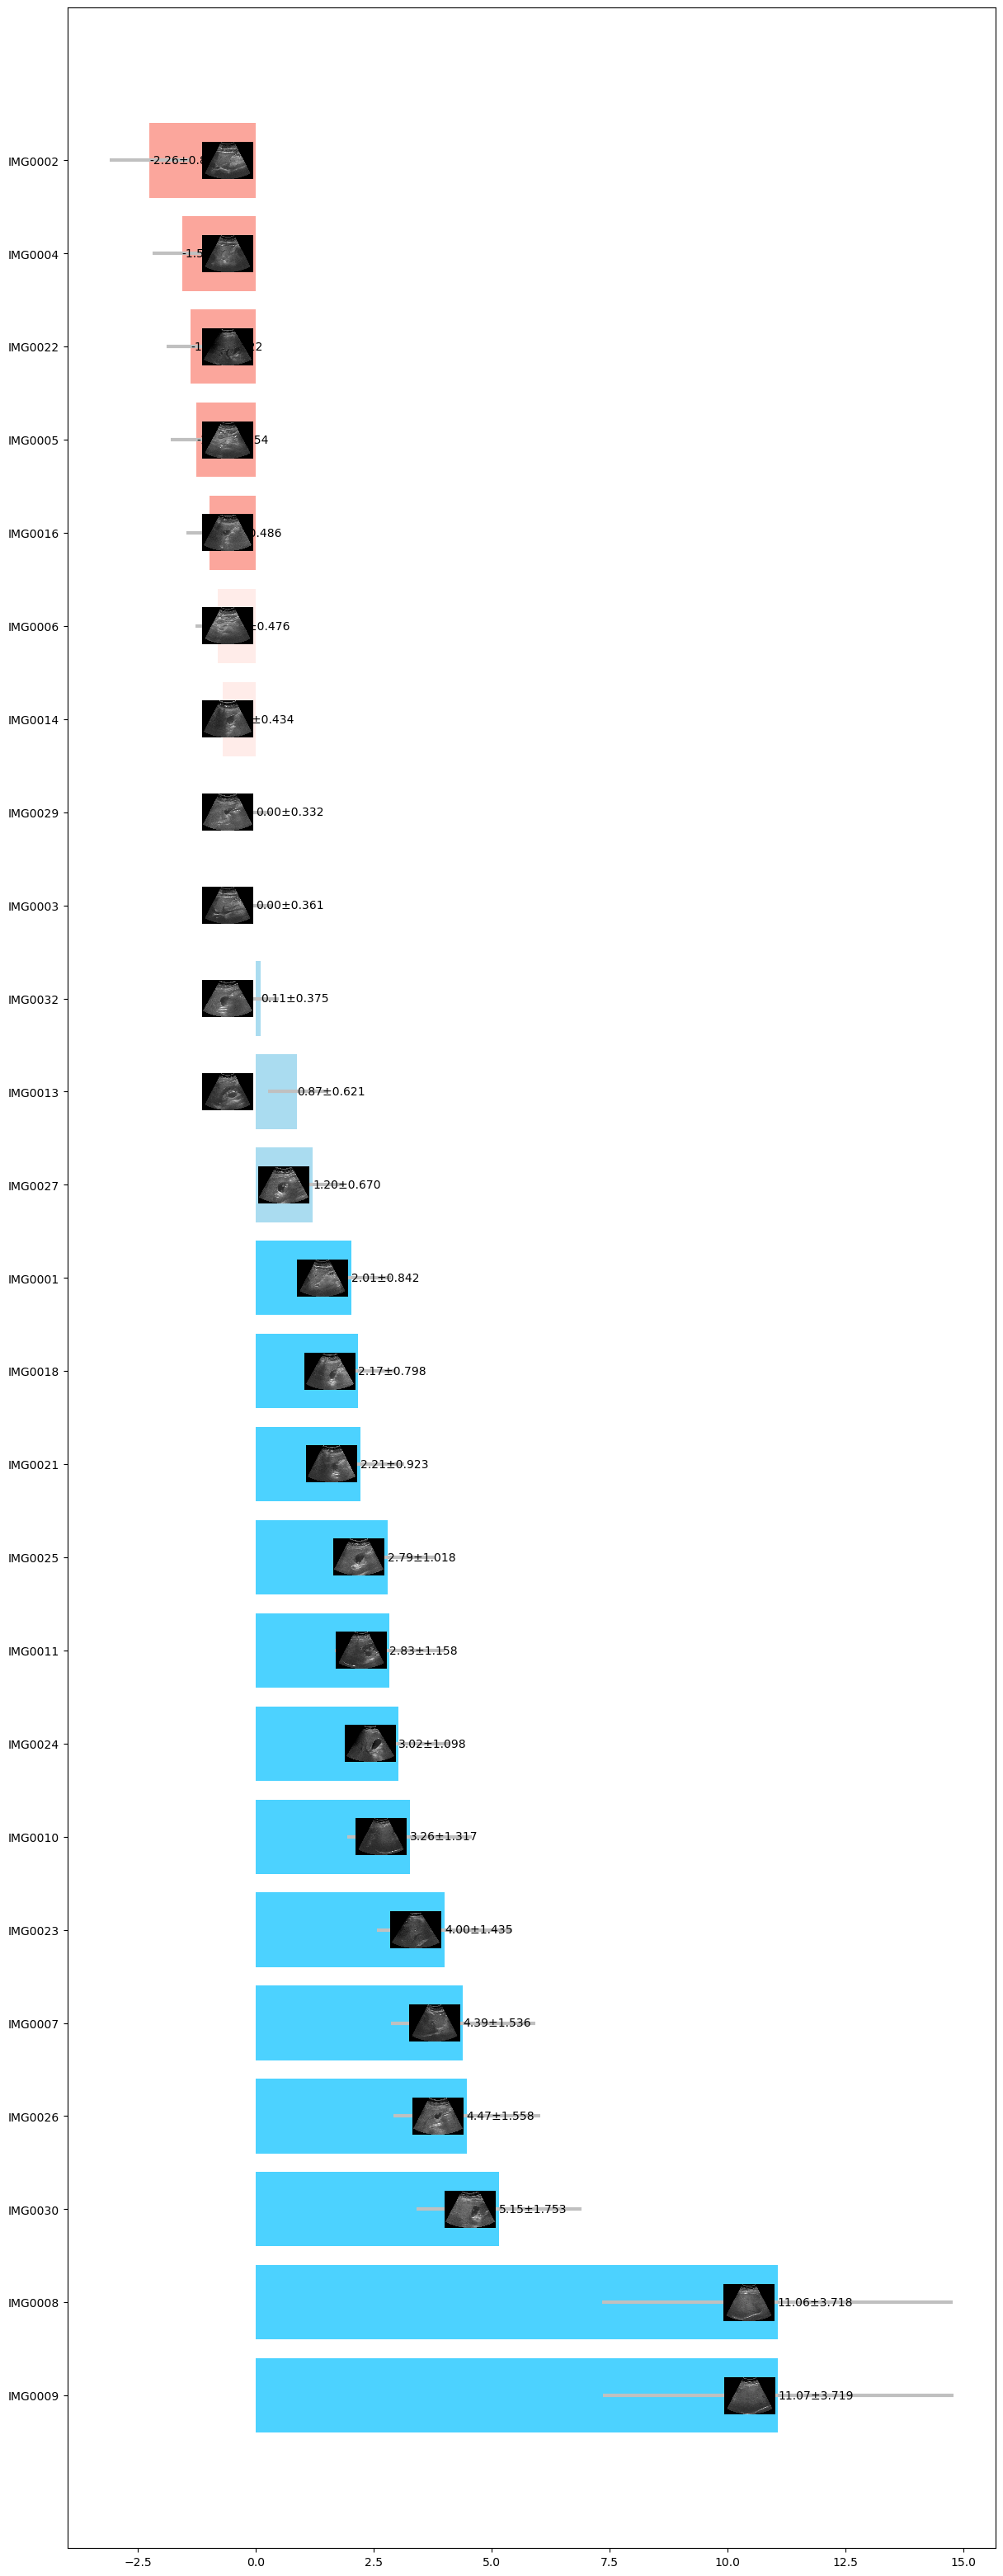

<Figure size 640x480 with 0 Axes>

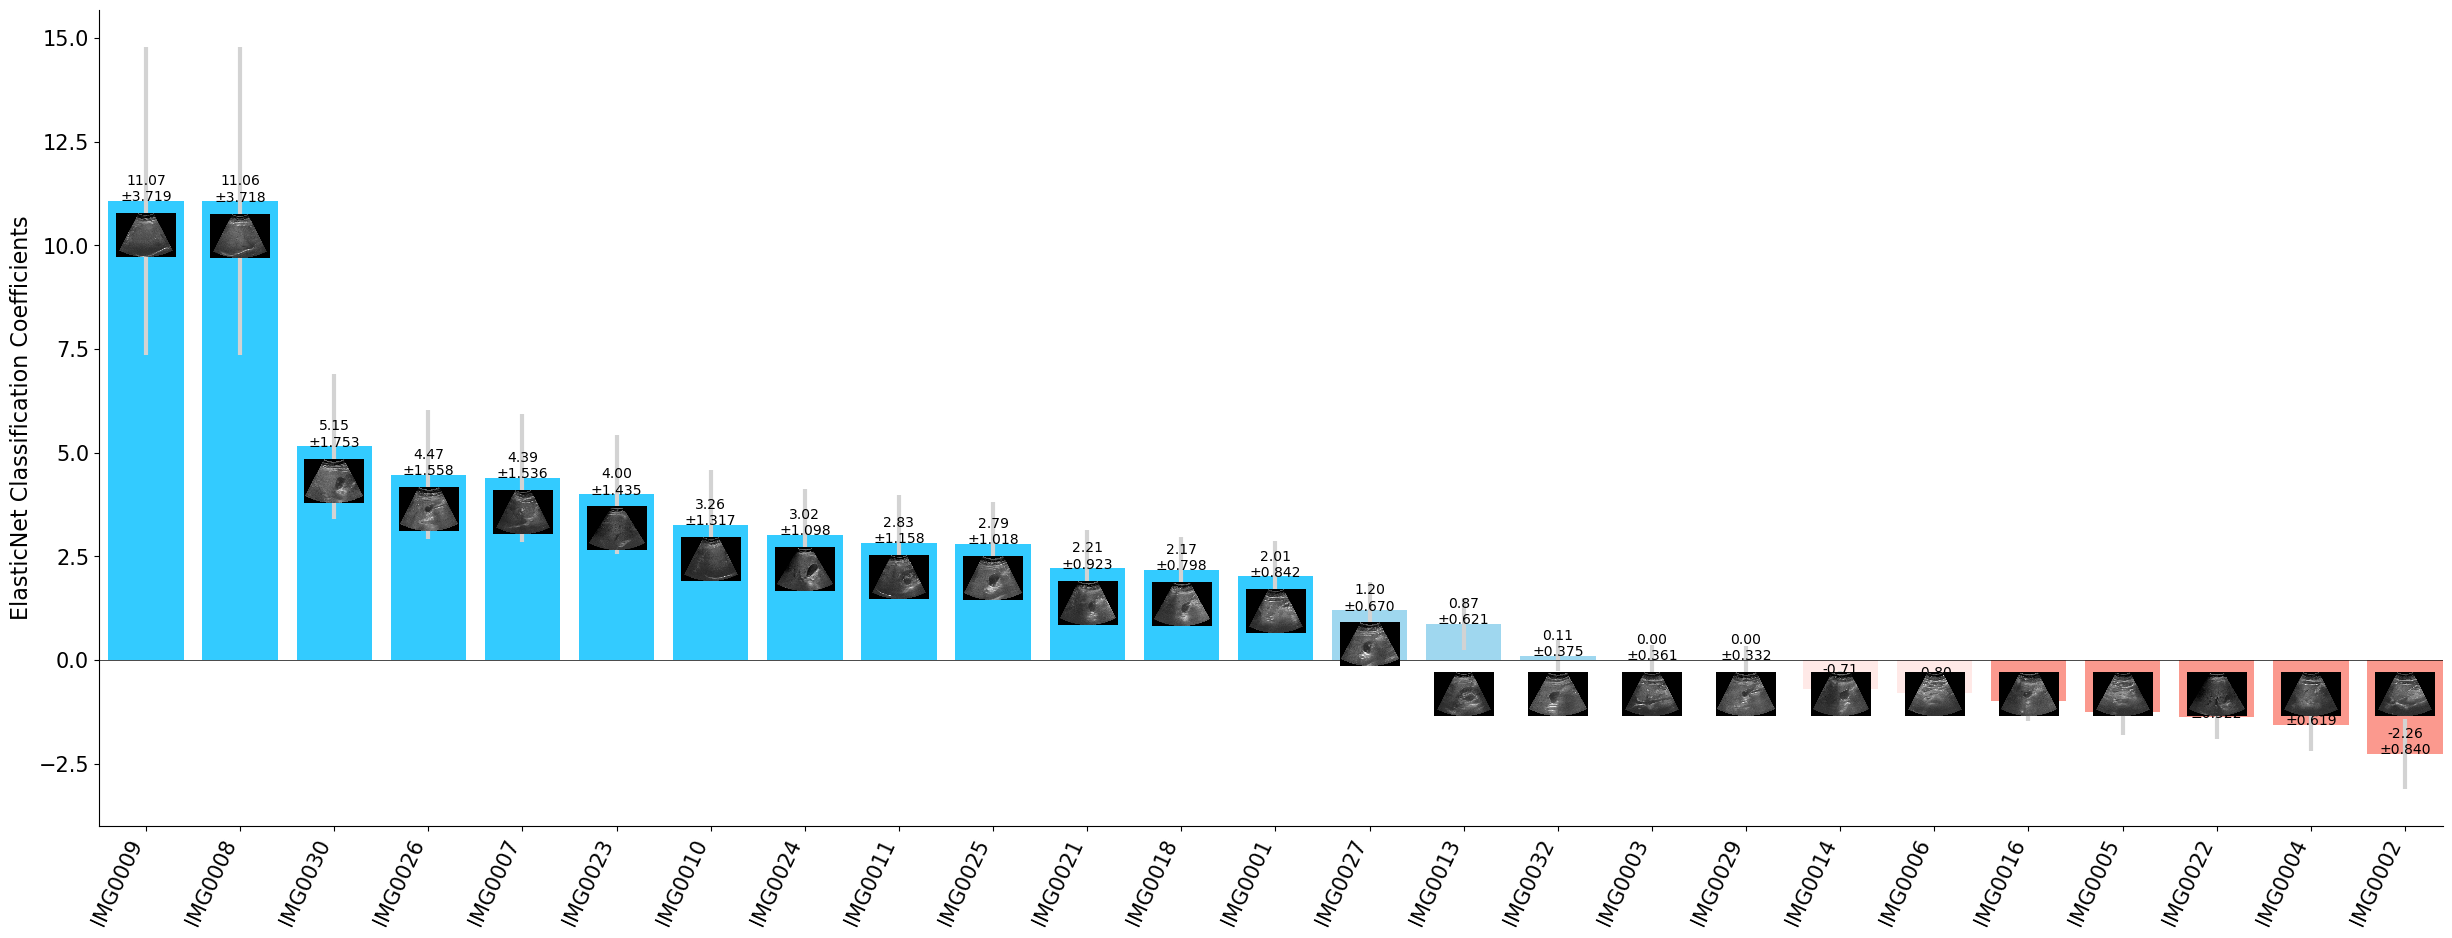

,Estimate,SE,BoostrapLowerCI,BoostrapUpperCI,SELowerCI,SEUpperCI,BootstrapSignificance,SESignificance
IMG0001,2.014605,0.842322,0.160457,3.382779,0.363655,3.665555,SIGNIFICANT,SIGNIFICANT
IMG0002,-2.260266,0.840007,-3.747829,-0.508930,-3.906679,-0.613852,SIGNIFICANT,SIGNIFICANT
IMG0003,0.000000,0.360653,-0.845411,0.725035,-0.706879,0.706879,INSIGNIFICANT,INSIGNIFICANT
IMG0004,-1.568804,0.618748,-2.575685,-0.227246,-2.781550,-0.356058,SIGNIFICANT,SIGNIFICANT
IMG0005,-1.258739,0.553959,-2.431127,-0.252062,-2.344498,-0.172979,SIGNIFICANT,SIGNIFICANT
IMG0006,-0.803826,0.476373,-1.724691,0.000000,-1.737518,0.129866,SIGNIFICANT,INSIGNIFICANT
IMG0007,4.391033,1.535684,0.888985,6.680885,1.381093,7.400973,SIGNIFICANT,SIGNIFICANT
IMG0008,11.060319,3.718474,2.443331,16.592780,3.772111,18.348528,SIGNIFICANT,SIGNIFICANT
IMG0009,11.067481,3.718935,2.484619,16.525605,3.778369,18.356593,SIGNIFICANT,SIGNIFICANT
IMG0010,3.259676,1.317439,0.333110,5.241170,0.677496,5.841856,SIGNIFICANT,SIGNIFICANT


<Figure size 640x480 with 0 Axes>

In [6]:

from classifiers import GLMNET_ElasticNetClassifierWithStats
# Fit model
model = GLMNET_ElasticNetClassifierWithStats(n_alphas=100, n_bootstrap_iterations=10000)
model.custom_fit(X_train, y_train)
model.visualize_alphas()

# Print summary
summary = model.summary()

# Calculate AUC on test set
y_pred_proba = model.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on holdout test set {auc}")
model.plot_results(img_abs_filepaths.copy(), save_dir = "/home/liuusa_tw/twbabd_image_xai_20062024/temp_FOLDCER")
summary

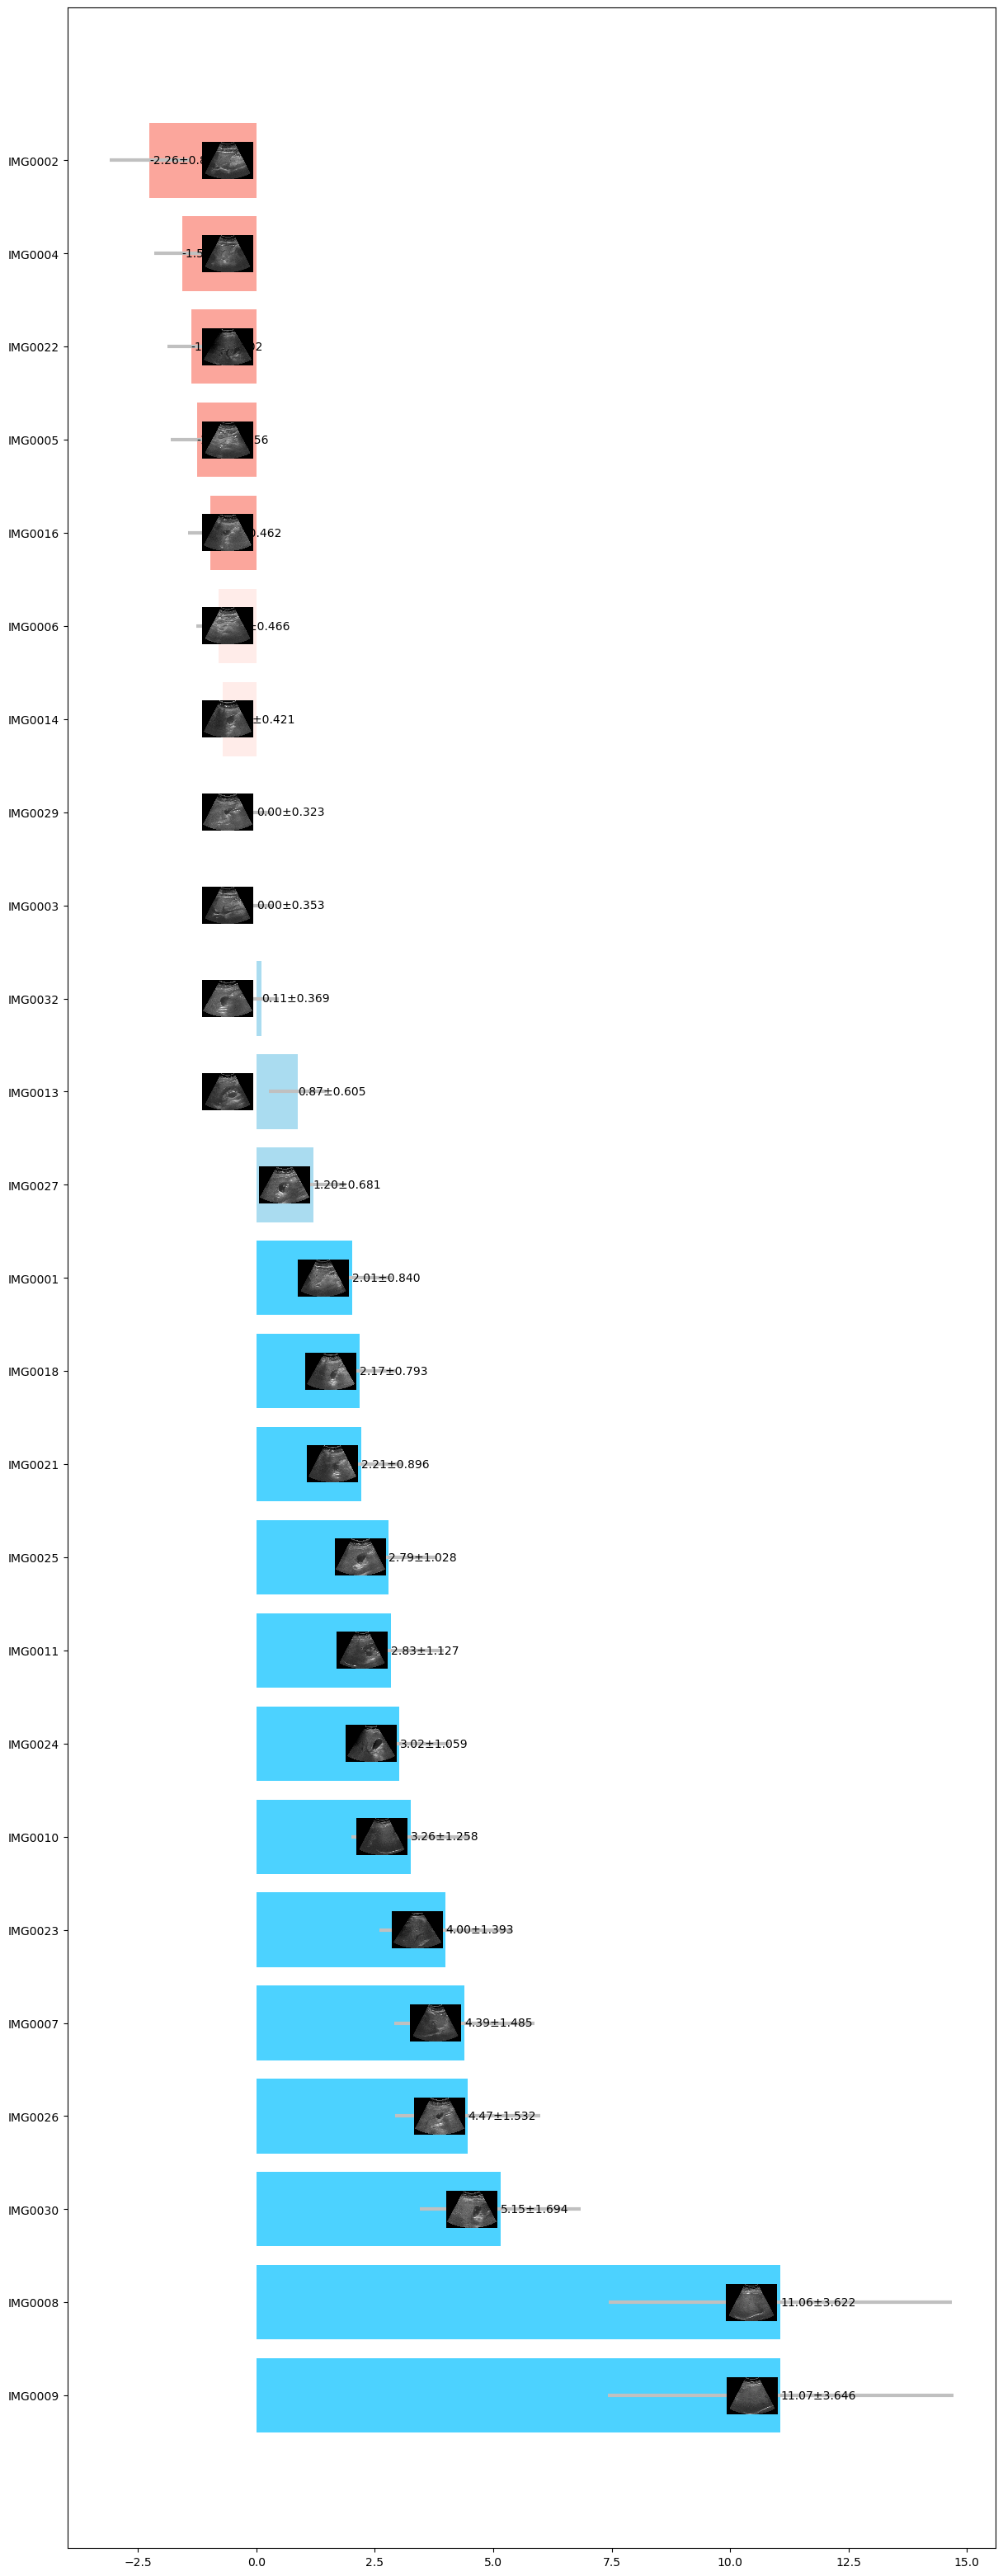

In [9]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure(figsize=(15,40)) 

def offset_image(x, y, img_path, bar_is_too_short, ax, zoom=0.06, vertical=False):
    img = plt.imread(img_path)
        
    im = OffsetImage(img, zoom=zoom, cmap='gray')
    im.image.axes = ax
    

    if vertical:
        # if y >= 0:
        #     xybox = (0, 10)  # Offset above the bar for positive values
        # else:
        #     xybox = (0, -10)  # Offset below the bar for negative values
            
        if bar_is_too_short:
            y = 0
        y_offset = -25 if y >= 0 else 25  # Adjust offset based on bar direction
        xybox = (0, y_offset)
    else:
        if bar_is_too_short:
            x = 0
        x_offset = -25 if x >= 0 else 25  # Adjust offset based on bar direction
        xybox = (x_offset, 0)
        
    ab = AnnotationBbox(im, (x, y), xybox=xybox, frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)

    ax.add_artist(ab)

labels = list(X_train.columns).copy()
values = [summary["Estimate"][i] 
            for i in range(len(labels))
            ]
upper_CIs = [summary["BoostrapUpperCI"][i] 
            for i in range(len(labels))
            ]
lower_CIs = [summary["BoostrapLowerCI"][i] 
            for i in range(len(labels))
            ]
ses = [summary["SE"][i] 
            for i in range(len(labels))
            ]
sesignificant = [summary["SESignificance"][i] for i in range (len(labels))]

sorted_img_filepaths = img_abs_filepaths.copy()
    
sorted_data = [(val, label, upper_CI, lower_CI, se, img_path, significance) for val, label, upper_CI, lower_CI, se, img_path, significance in 
               sorted(zip(values, labels, upper_CIs, lower_CIs, ses, sorted_img_filepaths, sesignificant), 
                                        key = lambda pair: pair[0], 
                                        reverse= True)]
values, labels, upper_CIs, lower_CIs, ses, sorted_img_filepaths, sesignificant = zip(*sorted_data)
del sorted_data

def get_color(val, significance):
    if val > 0 and significance == "SIGNIFICANT":
        return "deepskyblue"
    elif val < 0 and significance == "SIGNIFICANT":
        return "salmon"
    elif val > 0 and significance != "SIGNIFICANT":
        return "skyblue"
    elif val < 0 and significance != "SIGNIFICANT":
        return "mistyrose"
    else:
        return "white"
    
colors = [get_color(val, sesignificant[indx]) for indx, val in enumerate(values)]

zoom = 0.065


height = 0.8

bar_labels = [f"{values[indx]:.2f}±{se:.3f}" for indx, se in enumerate(ses)]

for indx, val in enumerate(values):
    plt.text(val, indx, bar_labels[indx],
                va='center',
                )
asymmetric_error = np.array(list(zip(lower_CIs, upper_CIs))).T

        
plt.barh(y=labels, width=values, 
            height=height, color=colors, 
            align='center', alpha=0.7, 
            xerr = ses, ecolor='silver',
            error_kw=dict(lw=3,),
        )

if isinstance(values, np.ndarray):
    max_value = values.max()
elif isinstance(values, (list, tuple, set)):
    max_value = max(values)
    
ax = plt.gca()
for indx, (label, value) in enumerate(zip(labels, values)):
    img_abs_filepath = sorted_img_filepaths[indx]
    offset_image(x = value, 
                    img_path = img_abs_filepath, 
                    y = label, 
                    bar_is_too_short=value < max_value / 10, 
                    zoom=zoom,
                    ax=ax,)
# plt.xlabel = "Ridge Classification Coefficients"
plt.subplots_adjust(left=0.15)
plt.show()

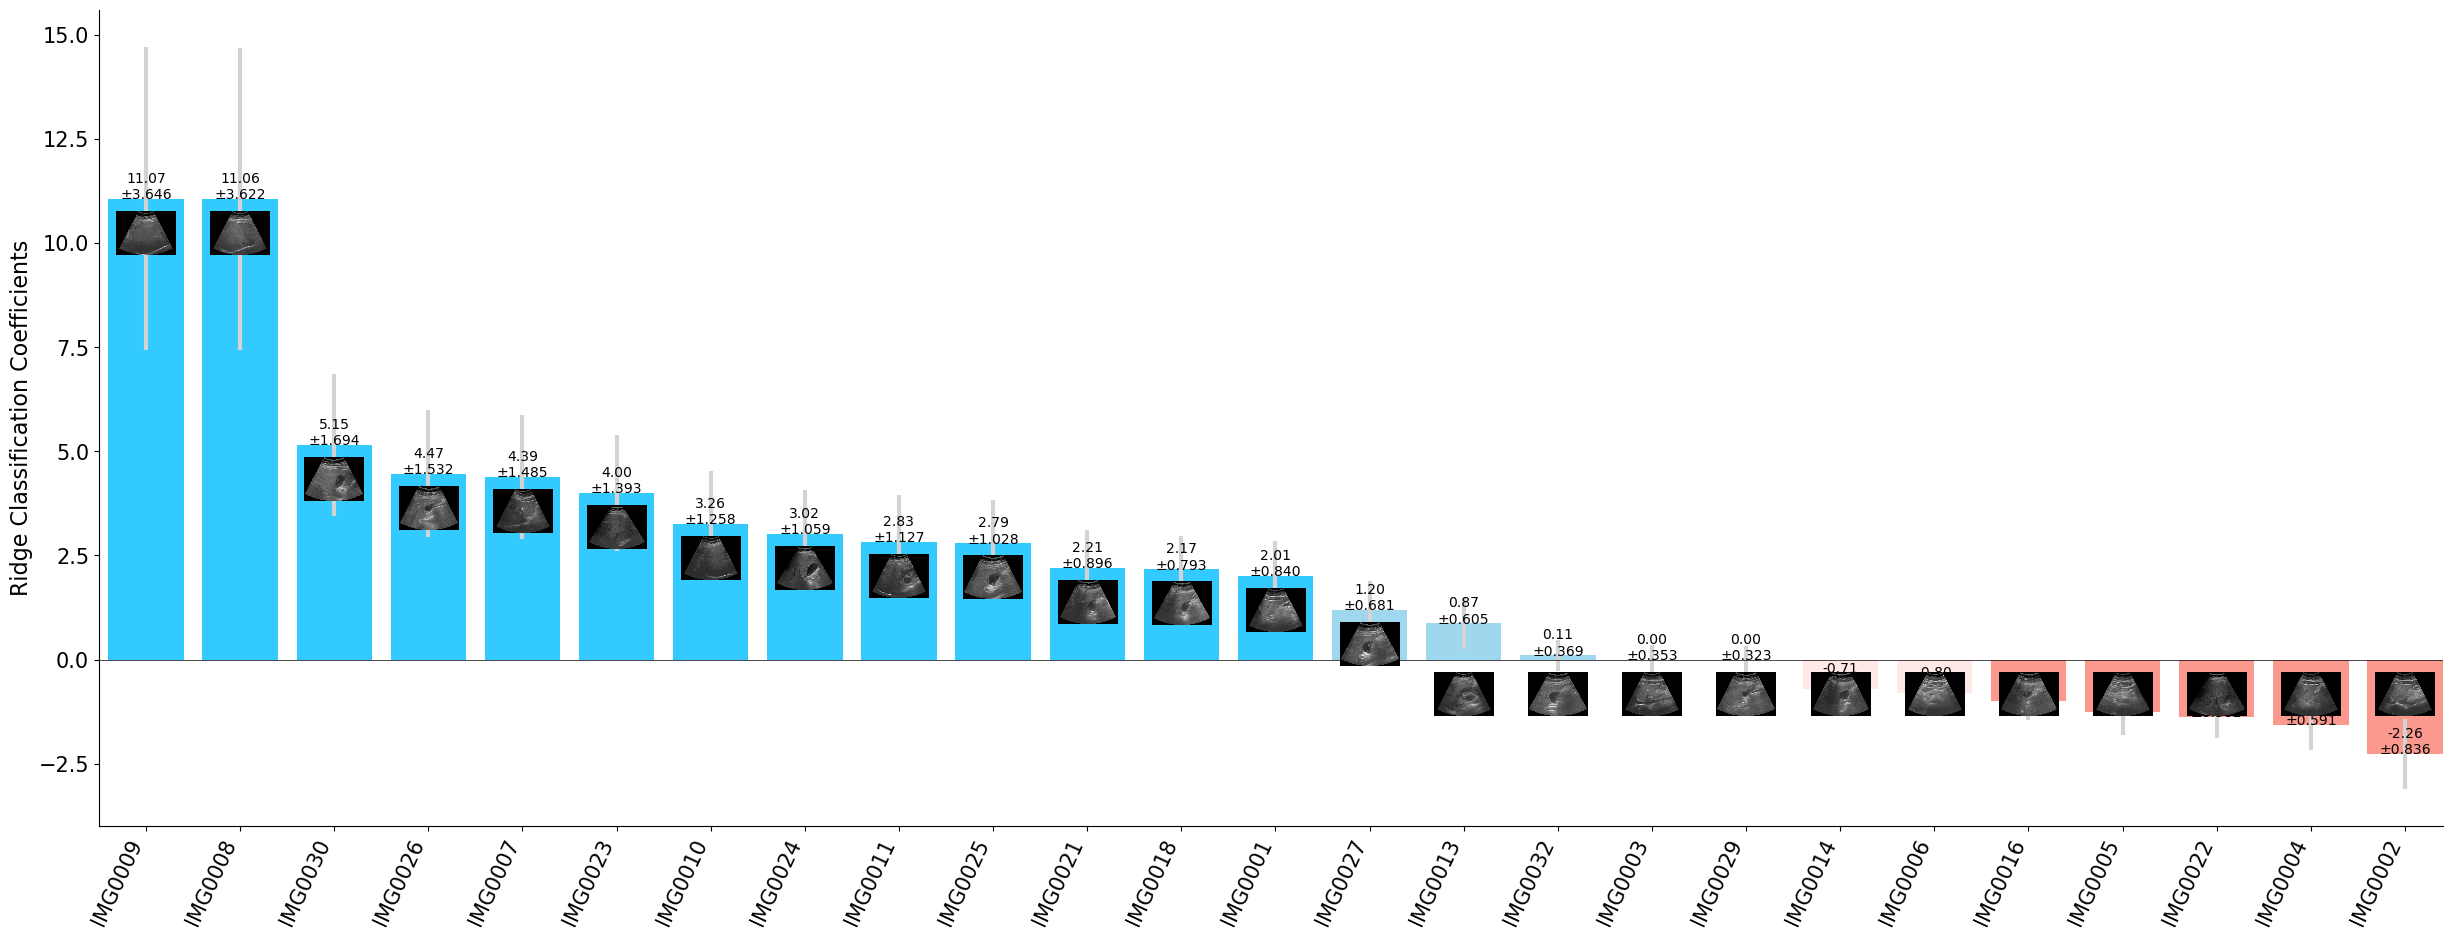

In [10]:
fig_width = len(labels) + len(labels)/4
fig_width = max(fig_width, 13)
fig_height = len(labels) // 2
fig_height = max(fig_height, 8)
plt.figure(figsize=(fig_width,fig_height))            

bar_labels = [f"{values[indx]:.2f}\n±{se:.3f}" for indx, se in enumerate(ses)]


zoom = 0.25 / 4
plt.bar(x=labels, height=values, 
        width=0.8, color=colors, 
        align='center', alpha=0.8, 
        yerr=ses, ecolor='lightgray', 
        error_kw=dict(lw=3,),
        )

for indx, val in enumerate(values):
    plt.text(indx, val, bar_labels[indx],
                ha='center',
                )
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlim(-0.5, len(labels) - 0.6)
    
for indx, (label, value) in enumerate(zip(labels, values)):
    img_abs_filepath = sorted_img_filepaths[indx]
    offset_image(y = value, img_path = img_abs_filepath, 
                    x = label, 
                    bar_is_too_short=value < max_value / 10, 
                    ax=ax, 
                    zoom=zoom, 
                    vertical=True)
    
# Set x-axis ticks and labels with larger font size
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=15)
ax.tick_params(axis='y', labelsize=15) 
plt.xticks(rotation=65, ha='right')
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(bottom=0.2)
ax.set_ylabel("Ridge Classification Coefficients", fontsize=16,)  # Adjust the title and font size as needed

# plt.savefig(os.path.join(self.result_dir,
#                 f"vbar.png"))
plt.show()

In [ ]:
model = RidgeClassifierWithStats(n_alphas=10000, n_bootstrap=10000)
model.custom_fit(X_train, y_train)

# Print summary
summary = model.summary()

# Calculate AUC on test set
y_pred_proba = model.custom_predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on test set: {auc:.4f}")
summary

: 

100%|██████████| 10000/10000 [00:22<00:00, 440.92it/s]


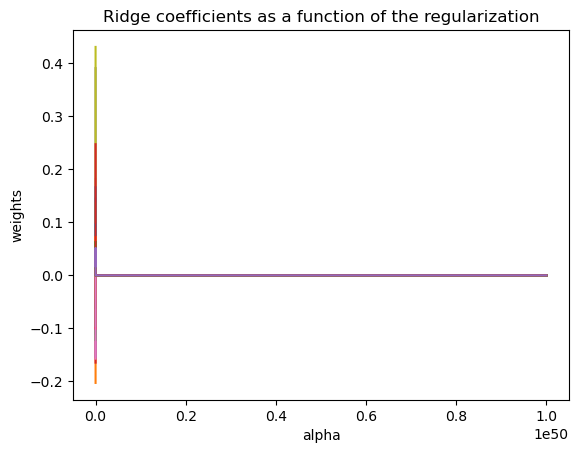

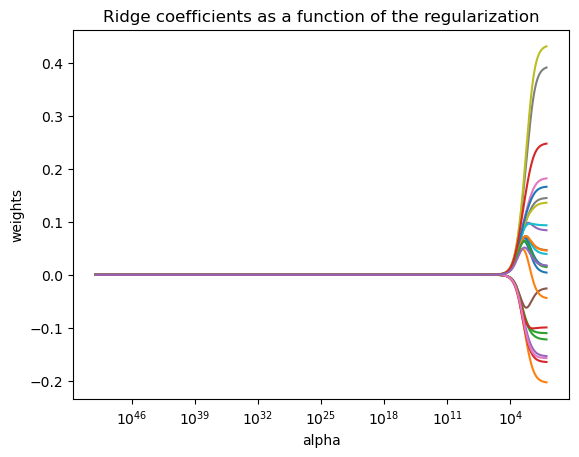

In [29]:

# Fit model
model = RidgeClassifierWithStats(n_alphas=1000, n_bootstrap=1000)
model.visualize_alphas(X_train, y_train)
model.custom_fit(X_train, y_train)

# Print summary
summary = model.summary()

# Calculate AUC on test set
y_pred_proba = model.custom_predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on test set: {auc:.4f}")
summary

In [36]:
from glmnet import LogitNet

m = LogitNet(fit_intercept=True, n_lambda=1000, alpha = 0.5, 
             standardize=False, n_splits=10, scoring= 'roc_auc', 
             n_jobs = 3, random_state=0)
m.fit(X_train, y_train)
print(np.count_nonzero(m.coef_), m.coef_,)
# print(np.count_nonzero(m.coef_.round(4)), m.coef_.round(4),)
# print(np.count_nonzero(m.coef_.round(3)), m.coef_.round(3),)
# print(np.count_nonzero(m.coef_.round(2)), m.coef_.round(2),)
m.score(X_test, y_test)

23 [[ 1.85428649 -2.08613236  0.         -1.48371819 -1.17047263 -0.73036208
   4.10547464 10.3699933  10.37598209  3.00922261  2.60110802  0.75577269
  -0.64943942 -0.89991855  2.00318381  2.03536538 -1.29688123  3.717163
   2.79904016  2.59591247  4.17037038  1.08305017  0.          4.82239085
   0.07714029]]


array(0.98765432)

In [23]:
X_train.shape, y_train.shape

((723, 25), (723,))

In [35]:
m = LogitNet(fit_intercept=True, n_lambda=1000, alpha = 0.5, 
             standardize=False, n_splits=10, scoring= 'roc_auc', 
             n_jobs = 3, random_state=0)

In [31]:
best_lambda = m.lambda_best_[0]
np.array([best_lambda])

array([0.00021166])

In [25]:
X_test.to

,IMG0001,IMG0002,IMG0003,IMG0004,IMG0005,IMG0006,IMG0007,IMG0008,IMG0009,IMG0010,...,IMG0021,IMG0022,IMG0023,IMG0024,IMG0025,IMG0026,IMG0027,IMG0029,IMG0030,IMG0032
199,1,0,0,0,1,1,1,1,0,1,...,0,0,0,0,1,1,1,0,0,1
837,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
174,0,1,0,0,0,1,0,0,1,1,...,0,0,0,1,0,1,0,1,1,0
554,0,1,1,1,1,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
570,0,1,1,1,1,1,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0,1,1,1,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
899,0,1,1,1,1,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
345,1,1,1,1,0,1,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
916,0,1,1,1,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0


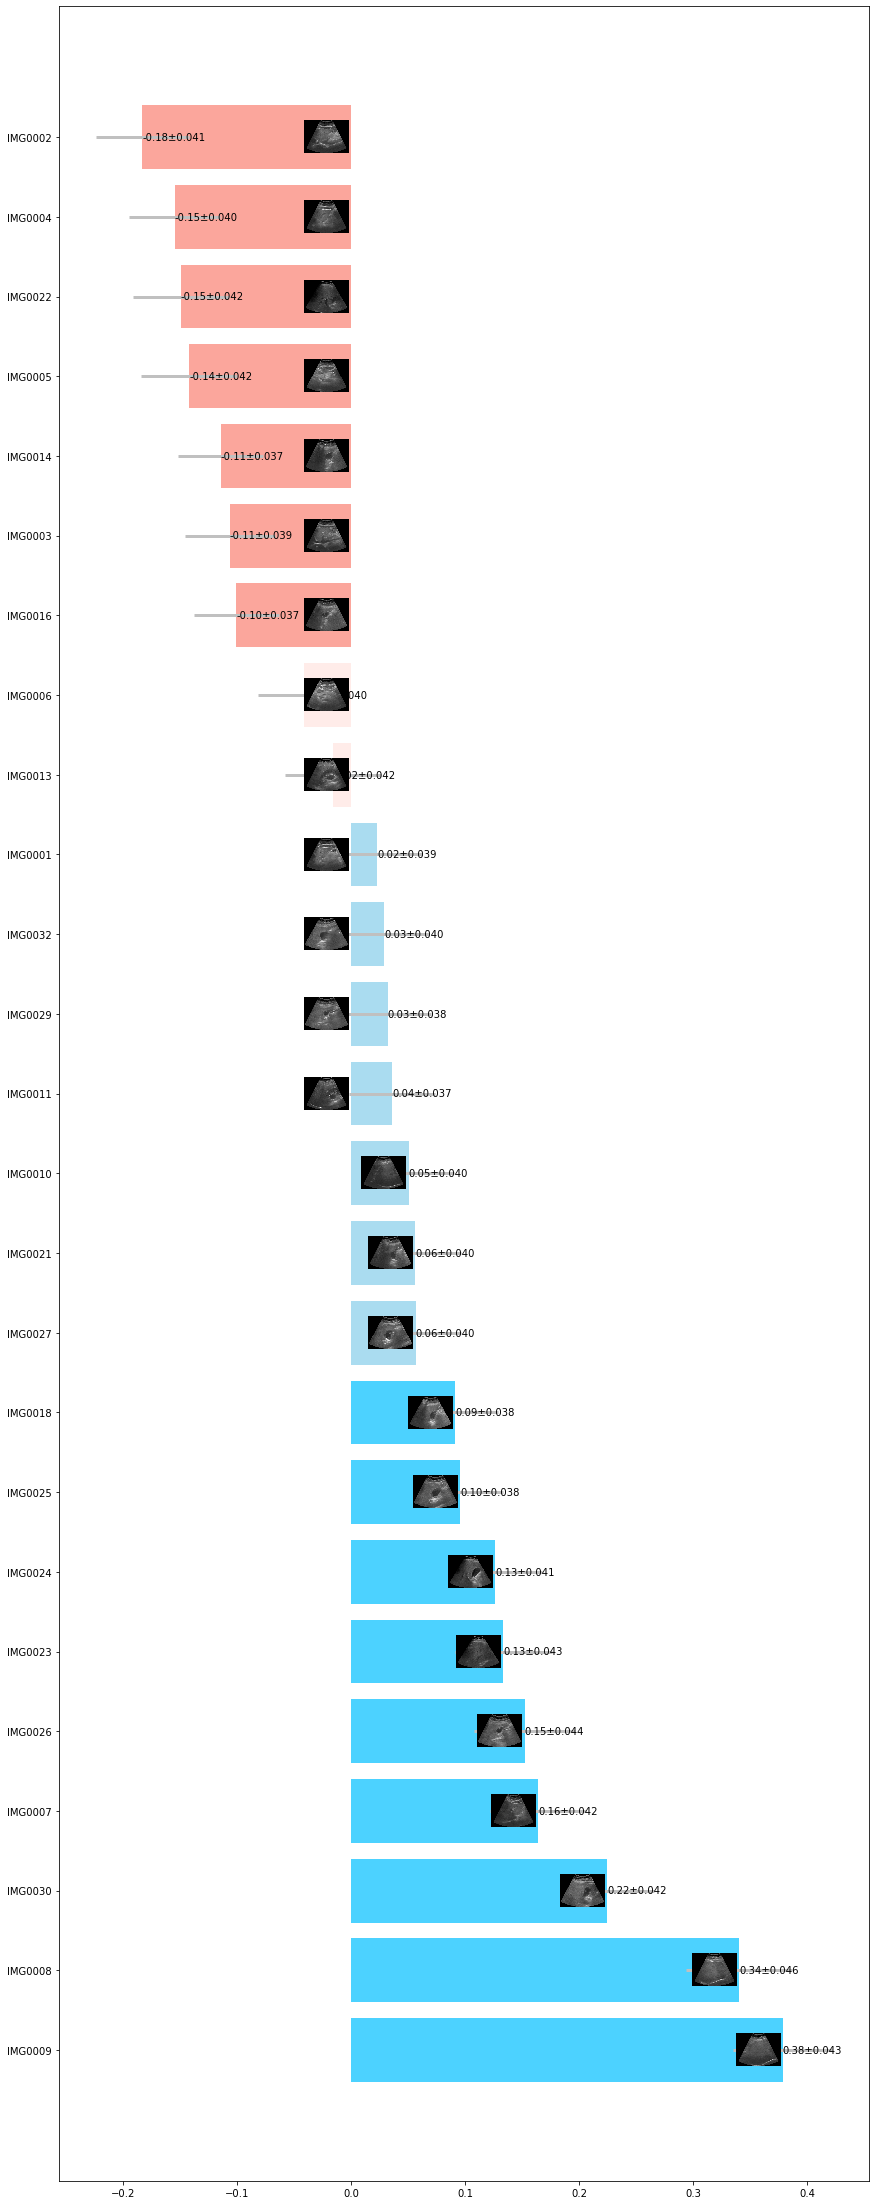

In [12]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure(figsize=(15,40)) 

def offset_image(x, y, img_path, bar_is_too_short, ax, zoom=0.06, vertical=False):
    img = plt.imread(img_path)
        
    im = OffsetImage(img, zoom=zoom, cmap='gray')
    im.image.axes = ax
    

    if vertical:
        # if y >= 0:
        #     xybox = (0, 10)  # Offset above the bar for positive values
        # else:
        #     xybox = (0, -10)  # Offset below the bar for negative values
            
        if bar_is_too_short:
            y = 0
        y_offset = -25 if y >= 0 else 25  # Adjust offset based on bar direction
        xybox = (0, y_offset)
    else:
        if bar_is_too_short:
            x = 0
        x_offset = -25 if x >= 0 else 25  # Adjust offset based on bar direction
        xybox = (x_offset, 0)
        
    ab = AnnotationBbox(im, (x, y), xybox=xybox, frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)

    ax.add_artist(ab)

labels = list(X_train.columns).copy()
values = [summary["Estimate"][i] 
            for i in range(len(labels))
            ]
upper_CIs = [summary["BoostrapUpperCI"][i] 
            for i in range(len(labels))
            ]
lower_CIs = [summary["BoostrapLowerCI"][i] 
            for i in range(len(labels))
            ]
ses = [summary["SE"][i] 
            for i in range(len(labels))
            ]
sesignificant = [summary["SESignificance"][i] for i in range (len(labels))]

sorted_img_filepaths = img_abs_filepaths.copy()
    
sorted_data = [(val, label, upper_CI, lower_CI, se, img_path, significance) for val, label, upper_CI, lower_CI, se, img_path, significance in 
               sorted(zip(values, labels, upper_CIs, lower_CIs, ses, sorted_img_filepaths, sesignificant), 
                                        key = lambda pair: pair[0], 
                                        reverse= True)]
values, labels, upper_CIs, lower_CIs, ses, sorted_img_filepaths, sesignificant = zip(*sorted_data)
del sorted_data

def get_color(val, significance):
    if val > 0 and significance == "SIGNIFICANT":
        return "deepskyblue"
    elif val < 0 and significance == "SIGNIFICANT":
        return "salmon"
    elif val > 0 and significance != "SIGNIFICANT":
        return "skyblue"
    elif val < 0 and significance != "SIGNIFICANT":
        return "mistyrose"
    else:
        return "white"
    
colors = [get_color(val, sesignificant[indx]) for indx, val in enumerate(values)]

zoom = 0.065


height = 0.8

bar_labels = [f"{values[indx]:.2f}±{se:.3f}" for indx, se in enumerate(ses)]

for indx, val in enumerate(values):
    plt.text(val, indx, bar_labels[indx],
                va='center',
                )
asymmetric_error = np.array(list(zip(lower_CIs, upper_CIs))).T

        
plt.barh(y=labels, width=values, 
            height=height, color=colors, 
            align='center', alpha=0.7, 
            xerr = ses, ecolor='silver',
            error_kw=dict(lw=3,),
        )

if isinstance(values, np.ndarray):
    max_value = values.max()
elif isinstance(values, (list, tuple, set)):
    max_value = max(values)
    
ax = plt.gca()
for indx, (label, value) in enumerate(zip(labels, values)):
    img_abs_filepath = sorted_img_filepaths[indx]
    offset_image(x = value, 
                    img_path = img_abs_filepath, 
                    y = label, 
                    bar_is_too_short=value < max_value / 10, 
                    zoom=zoom,
                    ax=ax,)
# plt.xlabel = "Ridge Classification Coefficients"
plt.subplots_adjust(left=0.15)
plt.show()

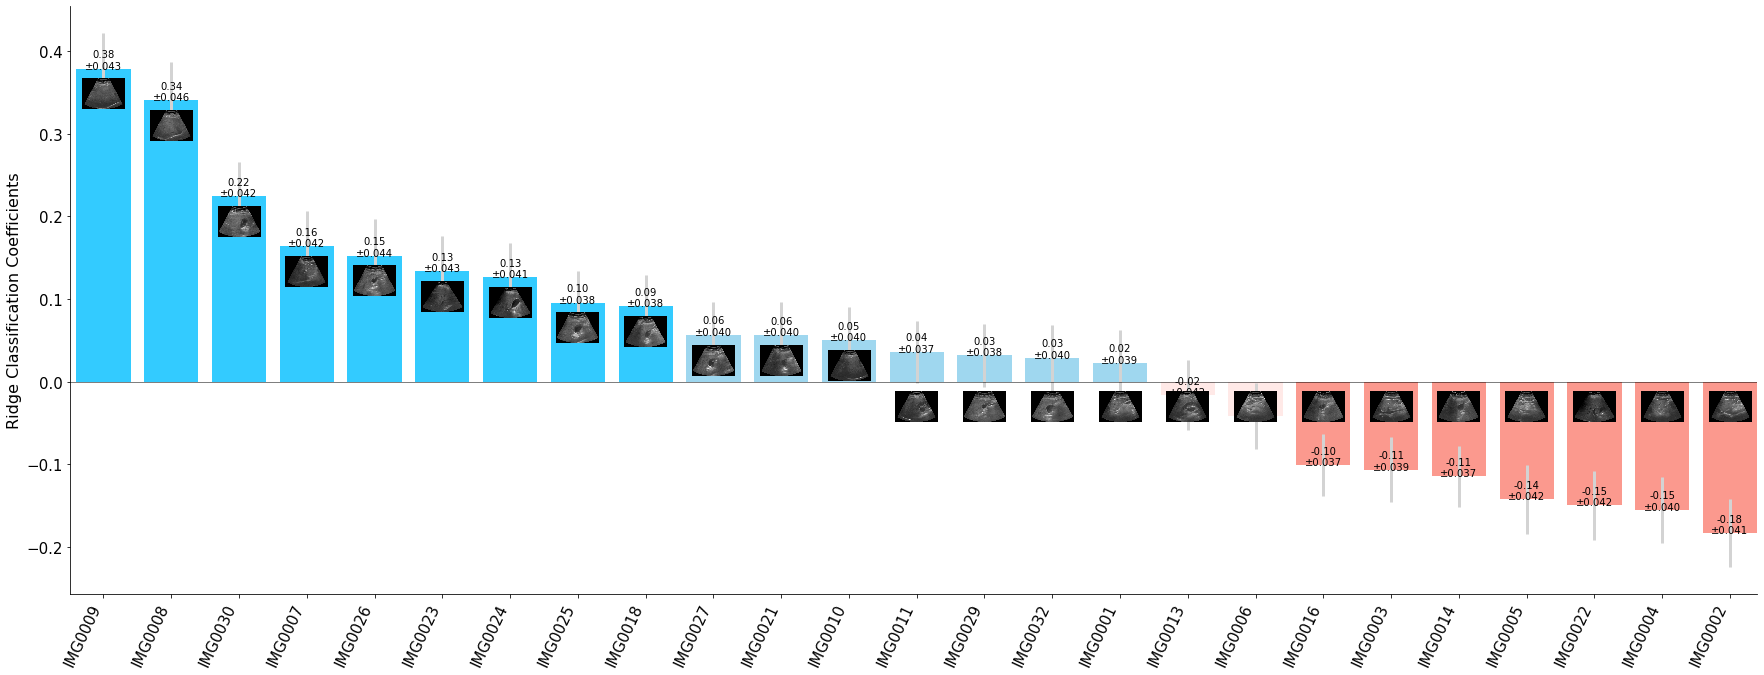

In [21]:
fig_width = len(labels) + len(labels)/4
fig_width = max(fig_width, 13)
fig_height = len(labels) // 2
fig_height = max(fig_height, 8)
plt.figure(figsize=(fig_width,fig_height))            

bar_labels = [f"{values[indx]:.2f}\n±{se:.3f}" for indx, se in enumerate(ses)]


zoom = 0.25 / 4
plt.bar(x=labels, height=values, 
        width=0.8, color=colors, 
        align='center', alpha=0.8, 
        yerr=ses, ecolor='lightgray', 
        error_kw=dict(lw=3,),
        )

for indx, val in enumerate(values):
    plt.text(indx, val, bar_labels[indx],
                ha='center',
                )
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlim(-0.5, len(labels) - 0.6)
    
for indx, (label, value) in enumerate(zip(labels, values)):
    img_abs_filepath = sorted_img_filepaths[indx]
    offset_image(y = value, img_path = img_abs_filepath, 
                    x = label, 
                    bar_is_too_short=value < max_value / 10, 
                    ax=ax, 
                    zoom=zoom, 
                    vertical=True)
    
# Set x-axis ticks and labels with larger font size
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=15)
ax.tick_params(axis='y', labelsize=15) 
plt.xticks(rotation=65, ha='right')
plt.subplots_adjust(left=0.15)
plt.subplots_adjust(bottom=0.2)
ax.set_ylabel("Ridge Classification Coefficients", fontsize=16,)  # Adjust the title and font size as needed

# plt.savefig(os.path.join(self.result_dir,
#                 f"vbar.png"))
plt.show()

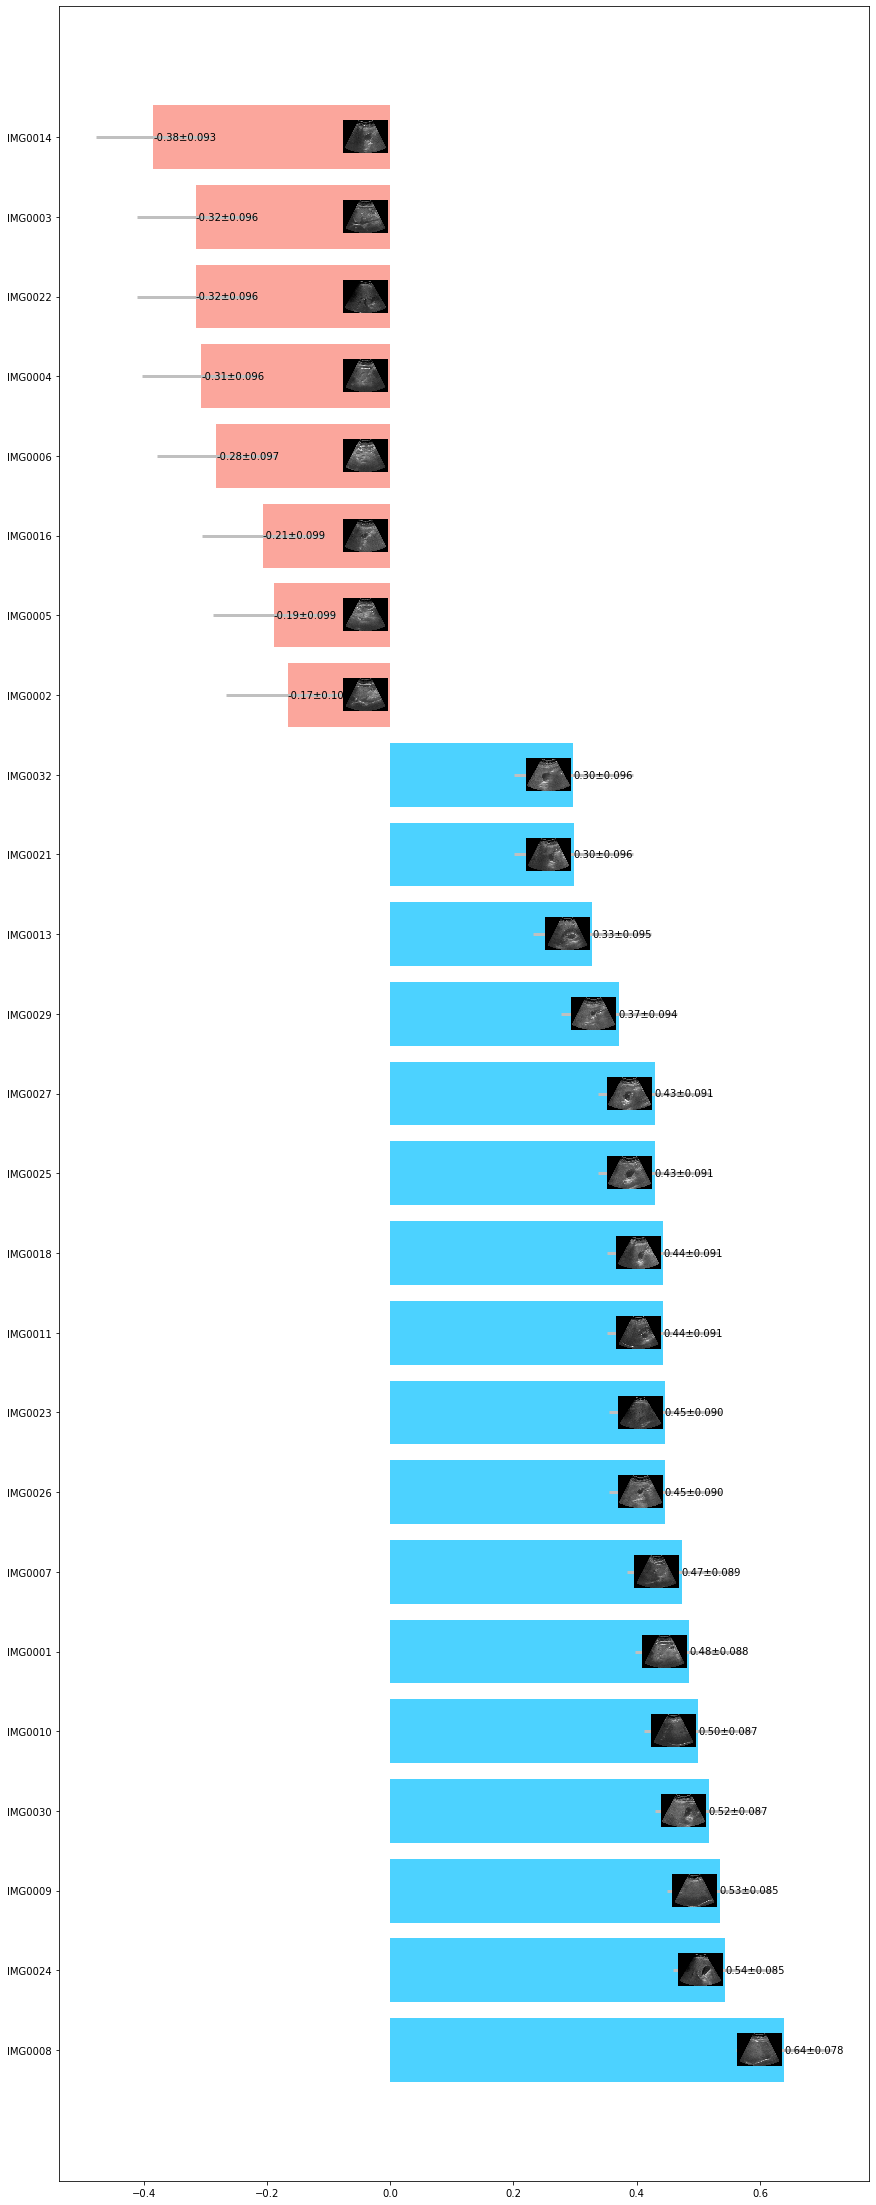

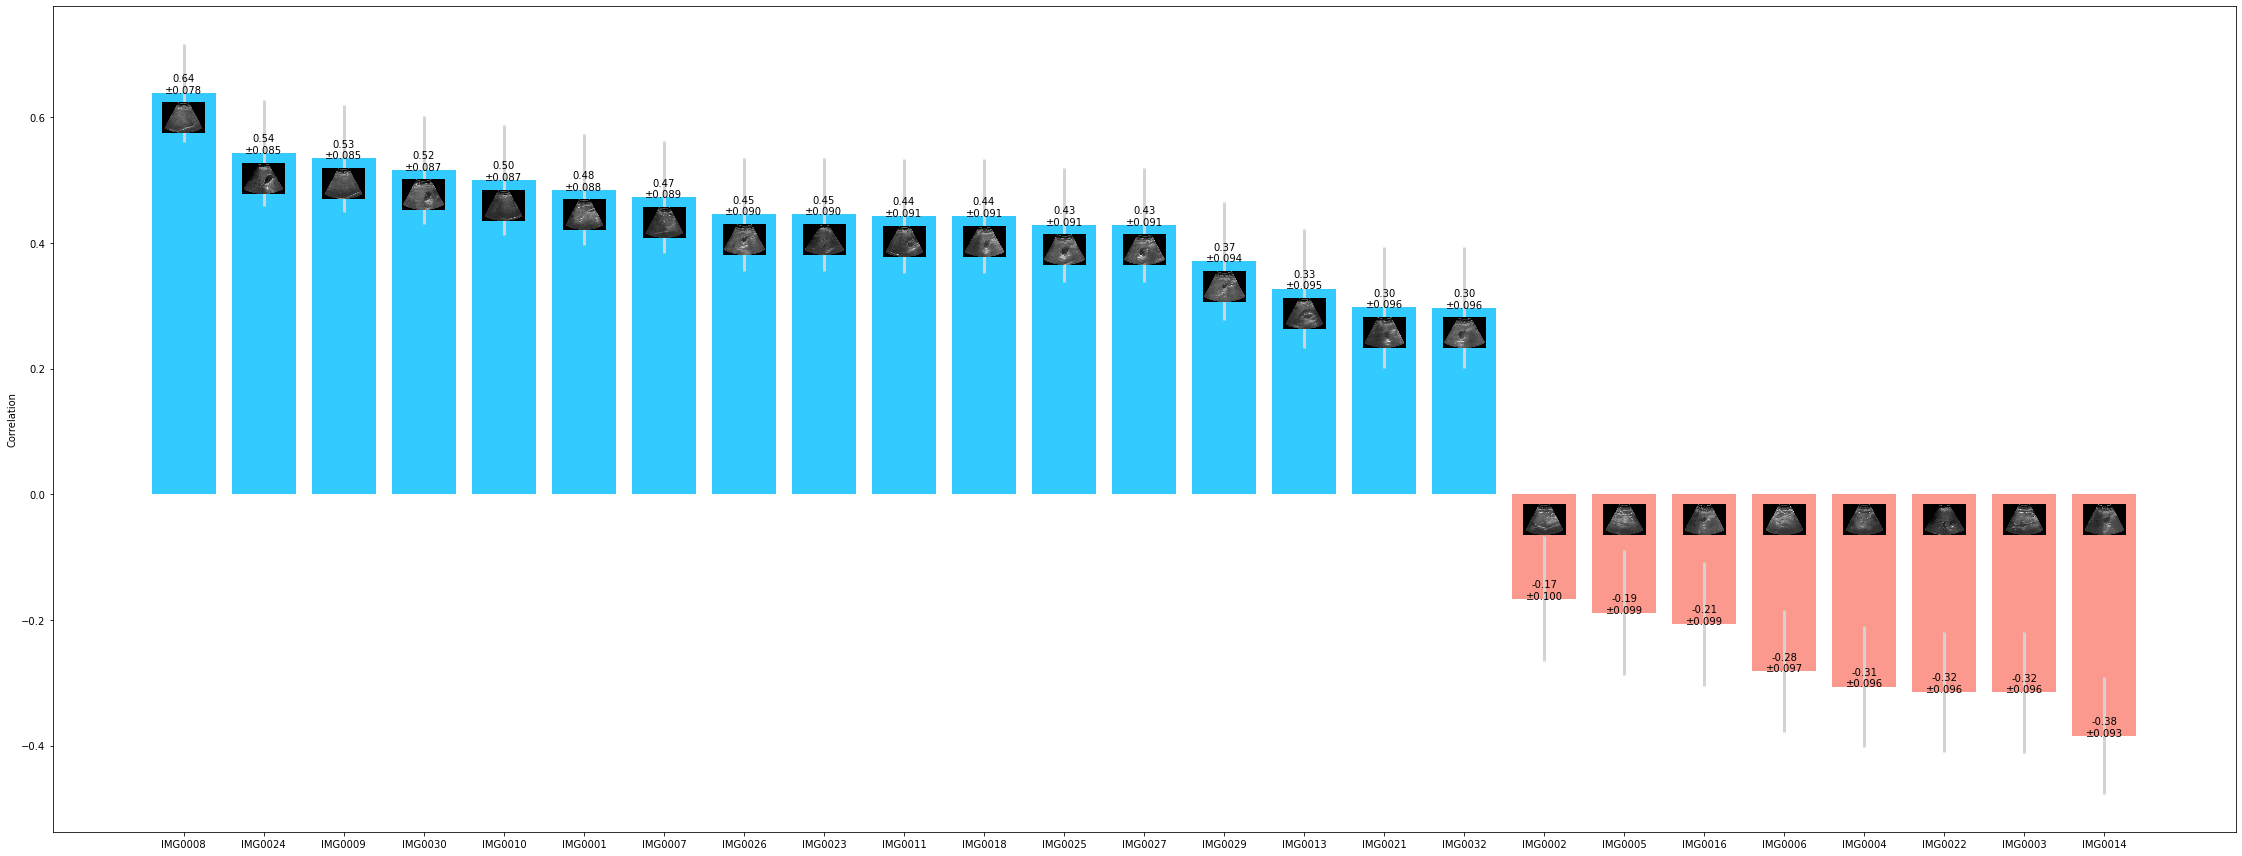

<Figure size 432x288 with 0 Axes>

In [39]:
mi_id_corr_df = pd.read_csv("/home/liuusa_tw/twbabd_image_xai_20062024/custom_lime_results/P0012750/corr_results.csv", index_col = 0)
plt.figure(figsize=(15,40)) 

def offset_image(x, y, img_path, bar_is_too_short, ax, zoom=0.06, vertical=False):
    img = plt.imread(img_path)
        
    im = OffsetImage(img, zoom=zoom, cmap='gray')
    im.image.axes = ax
    

    if vertical:
        # if y >= 0:
        #     xybox = (0, 10)  # Offset above the bar for positive values
        # else:
        #     xybox = (0, -10)  # Offset below the bar for negative values
            
        if bar_is_too_short:
            y = 0
        y_offset = -25 if y >= 0 else 25  # Adjust offset based on bar direction
        xybox = (0, y_offset)
    else:
        if bar_is_too_short:
            x = 0
        x_offset = -25 if x >= 0 else 25  # Adjust offset based on bar direction
        xybox = (x_offset, 0)
        
    ab = AnnotationBbox(im, (x, y), xybox=xybox, frameon=False,
                        xycoords='data', boxcoords="offset points", pad=0)

    ax.add_artist(ab)

values = list(mi_id_corr_df['corr'])
labels = list(mi_id_corr_df.index)
stds = list(mi_id_corr_df['corr_std'])

label_val = [(val, label, std) for val, label, std in sorted(zip(values, labels, stds), 
                                        key = lambda pair: pair[0], 
                                        reverse= True)]
values, labels, stds = zip(*label_val)
del label_val

colors = ["deepskyblue" 
            if val > 0 
            else "salmon" 
            for val in values]

zoom = 0.065

height = 0.8


bar_labels = [f"{values[indx]:.2f}±{std:.3f}" for indx, std in enumerate(stds)]

for indx, val in enumerate(values):
    plt.text(val, indx, bar_labels[indx],
                va='center',
                )

        
plt.barh(y=labels, width=values, 
            height=height, color=colors, 
            align='center', alpha=0.7, 
            xerr = stds, ecolor='silver',
            error_kw=dict(lw=3,),
        )

if isinstance(values, np.ndarray):
    max_value = values.max()
elif isinstance(values, (list, tuple, set)):
    max_value = max(values)
    
ax = plt.gca()
for _, (label, value) in enumerate(zip(labels, values)):    
    img_abs_filepath = CROP_IMAGE_DIR + str(mi_id) +'_'+str(label)+'.jpg' 
    offset_image(x = value, 
                    img_path = img_abs_filepath, 
                    y = label, 
                    bar_is_too_short=value < max_value / 10, 
                    zoom=zoom,
                    ax=ax,)
plt.subplots_adjust(left=0.15)
plt.show()
plt.clf()
plt.close()

fig_width = len(labels) + len(labels)/4
fig_width = max(fig_width, 13)
fig_height = len(labels) // 2
fig_height = max(fig_height, 8)
fig = plt.figure(figsize=(fig_width,fig_height))            

bar_labels = [f"{values[indx]:.2f}\n±{std:.3f}" for indx, std in enumerate(stds)]

for indx, val in enumerate(values):
    plt.text(indx, val, 
                bar_labels[indx], 
                ha='center', 
                ) 


zoom = 0.25 / 4
plt.bar(x=labels, height=values, 
        width=0.8, color=colors, 
        align='center', alpha=0.8, 
        yerr=stds, ecolor='lightgray', 
        error_kw=dict(lw=3,),
        )
ax = plt.gca()
    
for _, (label, value) in enumerate(zip(labels, values)):
    img_abs_filepath = CROP_IMAGE_DIR + str(mi_id) +'_'+str(label)+'.jpg' 

    offset_image(y = value, img_path = img_abs_filepath, 
                    x = label, 
                    bar_is_too_short=value < max_value / 10, 
                    ax=ax, 
                    zoom=zoom, 
                    vertical=True)
ax.set_ylabel("Correlation")
plt.subplots_adjust(left=0.15)
plt.tight_layout()
fig.tight_layout()
fig.set_tight_layout(True)
fig.patch.set_facecolor('white')
fig.savefig("asfdsfsa.png", bbox_inches='tight', dpi=450, transparent=False)
plt.show()
plt.clf()

In [41]:
corr_values = values

In [49]:
corr_values = list(mi_id_corr_df['corr'])
corr_labels = list(mi_id_corr_df.index)

ridge_labels = list(X_train.columns).copy()
ridge_values = [summary["Estimate"][i] 
            for i in range(len(labels))
            ]
corr_labels == ridge_labels

True

In [50]:
from scipy import stats
res = stats.spearmanr(corr_values, ridge_values)
res.correlation, res.pvalue

(0.8541747457974542, 5.576819925309284e-08)

# Breast cancer test dataset

In [ ]:
# Example usage:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Load and prepare data
data = load_breast_cancer()
X, y = data.data, data.target
X = StandardScaler().fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = RidgeClassifierWithStats(n_alphas=1000, n_bootstrap=1000)
model.custom_fit(X_train, y_train)

# Print summary
summary = model.summary()

# Calculate AUC on test set
y_pred_proba = model.custom_predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC on test set: {auc:.4f}")
summary

Mean accuracy:  0.9692307692307692
Best alpha value:  2.8864255513484176
Intercept value:  0.24429519900539134
AUC on test set: 0.9931


,Estimate,SE,BoostrapLowerCI,BoostrapUpperCI,SELowerCI,SEUpperCI,pval
0,-0.197656,0.069816,-0.309522,-0.035711,-0.267473,-0.127840,0.800
1,-0.031618,0.079636,-0.182872,0.135276,-0.111254,0.048018,0.940
2,-0.130999,0.062485,-0.234445,0.006929,-0.193484,-0.068514,0.830
3,0.181145,0.107631,-0.059560,0.366281,0.073514,0.288776,0.894
4,0.010936,0.049378,-0.084692,0.109003,-0.038442,0.060313,0.997
5,0.339762,0.091499,0.144704,0.504705,0.248262,0.431261,0.897
6,-0.145819,0.118044,-0.384409,0.075327,-0.263863,-0.027775,0.985
7,-0.288881,0.109936,-0.519270,-0.086704,-0.398817,-0.178945,0.947
8,0.037535,0.041865,-0.050762,0.114465,-0.004330,0.079399,0.937
9,-0.001008,0.065296,-0.121477,0.130417,-0.066304,0.064287,0.919


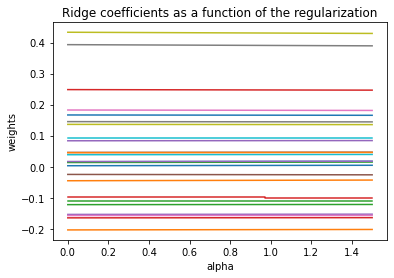

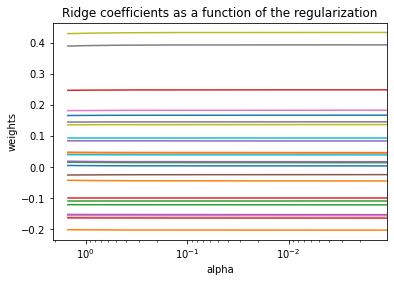

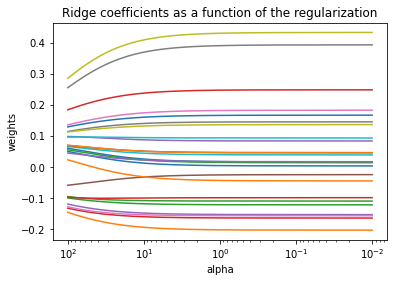

In [ ]:

n_alphas = 1000
alphas = np.linspace(0.0, 1.5, num = n_alphas)

coefs = []
for a in alphas:
    ridge = RidgeClassifier(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_[0])
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("linear")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()


ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()


alphas = np.logspace(-2, 2, n_alphas)

coefs = []
for a in alphas:
    ridge = RidgeClassifier(alpha=a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_[0])
    
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()